  observation_date  PCECTPI      Infl
1       1947-04-01   11.649  3.171610
2       1947-07-01   11.866  7.382731
3       1947-10-01   12.162  9.855668
4       1948-01-01   12.297  4.415597
5       1948-04-01   12.424  4.109902
Sample period observations: 228


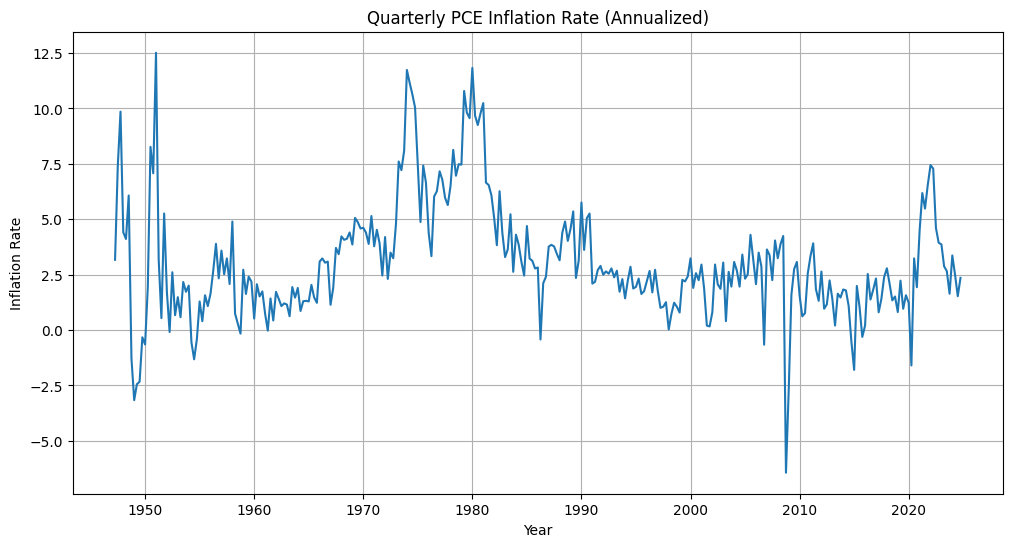

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '/Users/kaiusevans/Downloads/PCECTPI-2.csv'
data = pd.read_csv(file_path)

data['observation_date'] = pd.to_datetime(data['observation_date'])
data = data.sort_values('observation_date')

data['ln_PCEP'] = np.log(data['PCECTPI'])
data['Infl'] = 400 * (data['ln_PCEP'] - data['ln_PCEP'].shift(1))
data = data.dropna()

print(data[['observation_date', 'PCECTPI', 'Infl']].head())

sample_data = data[(data['observation_date'] >= '1963-01-01') & (data['observation_date'] <= '2019-12-31')]
print(f"Sample period observations: {len(sample_data)}")

plt.figure(figsize=(12, 6))
plt.plot(data['observation_date'], data['Infl'])
plt.title('Quarterly PCE Inflation Rate (Annualized)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate')
plt.grid(True)
plt.show()

In [ ]:
The inflation rate, Infl, is measured in **percentage points per year**. It’s calculated as the quarterly log difference in the PCE 
price index, multiplied by 400. The 400 comes from converting the quarterly growth rate into an annualized percentage (100 for percent, 
4 for quarters). So if Infl = 3.5, that means prices were rising at an annualized rate of 3.5% that quarter.

In [ ]:
B)

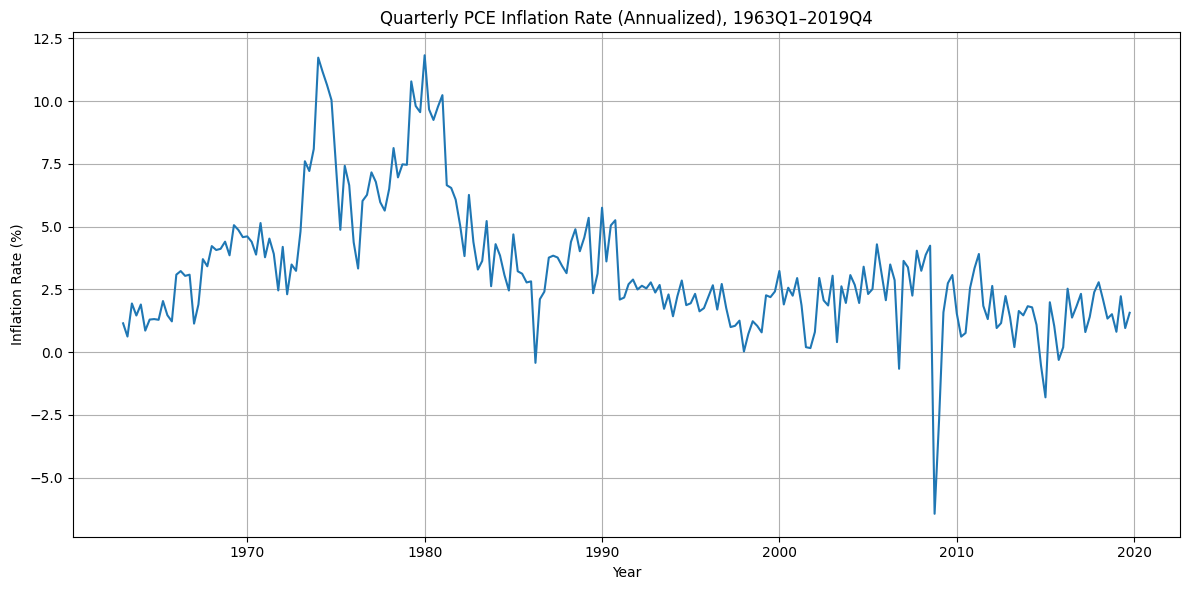

ADF Statistic: -2.786458
p-value: 0.060234
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


In [10]:
from statsmodels.tsa.stattools import adfuller

sample_data = data[(data['observation_date'] >= '1963-01-01') & (data['observation_date'] <= '2019-12-31')]
sample_data = sample_data.dropna()

plt.figure(figsize=(12, 6))
plt.plot(sample_data['observation_date'], sample_data['Infl'])
plt.title('Quarterly PCE Inflation Rate (Annualized), 1963Q1–2019Q4')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

result = adfuller(sample_data['Infl'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
Based on the plot, inflation doesn’t appear to have a stochastic trend. It fluctuates over time but generally reverts to a central level,
especially after the high-inflation period in the 1970s–1980s. The variation doesn’t grow without bound like a random walk would. This 
suggests inflation is likely stationary or trend-stationary rather than following a unit root process.

In [ ]:
C)

Autocorrelations of the change in inflation:
Lag 1: -0.2528
Lag 2: -0.2078
Lag 3: 0.1295
Lag 4: -0.0765


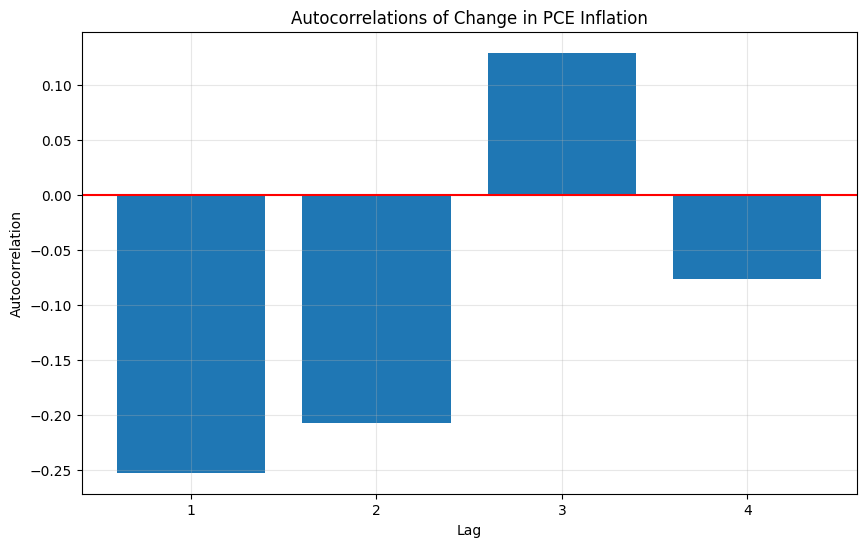

In [11]:
from statsmodels.tsa.stattools import acf

data['change_Infl'] = data['Infl'] - data['Infl'].shift(1)
sample_data = data[(data['observation_date'] >= '1963-01-01') & (data['observation_date'] <= '2019-12-31')]
sample_data = sample_data.dropna()

autocorr = acf(sample_data['change_Infl'], nlags=4)

print("Autocorrelations of the change in inflation:")
for i in range(1, 5):
    print(f"Lag {i}: {autocorr[i]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(1, 5), autocorr[1:5])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelations of Change in PCE Inflation')
plt.xticks(range(1, 5))
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
D)

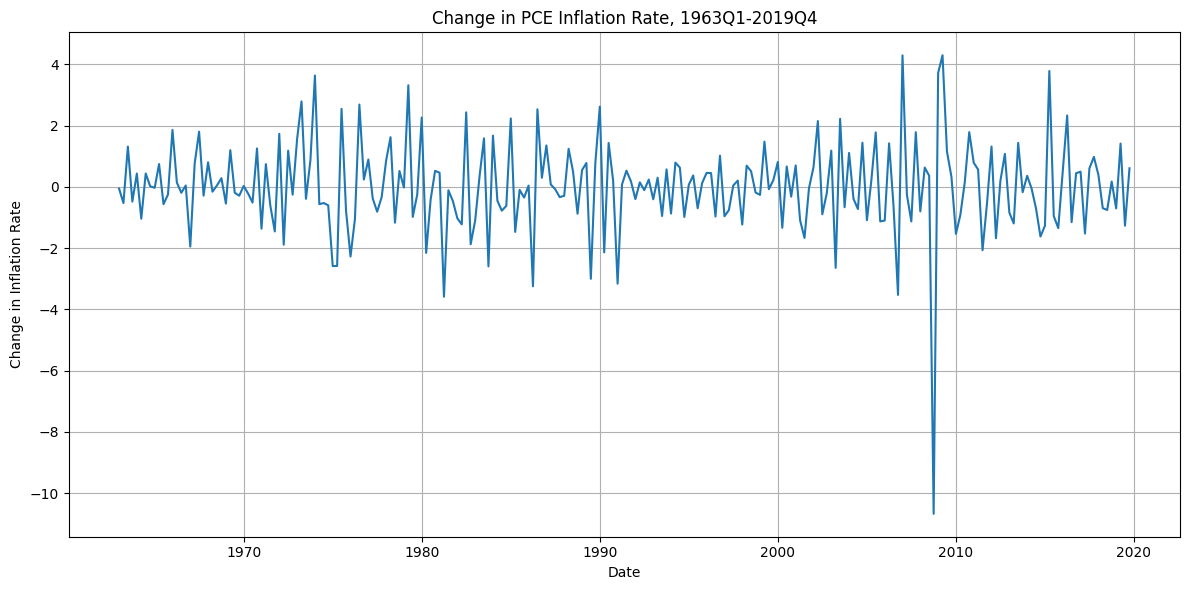

First autocorrelation of change_Infl: -0.2528


In [12]:
autocorr = acf(sample_data['change_Infl'], nlags=4)

plt.figure(figsize=(12, 6))
plt.plot(sample_data['observation_date'], sample_data['change_Infl'])
plt.title('Change in PCE Inflation Rate, 1963Q1-2019Q4')
plt.xlabel('Date')
plt.ylabel('Change in Inflation Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"First autocorrelation of change_Infl: {autocorr[1]:.4f}")

In [ ]:
The plot of the change in inflation looks very choppy and moves up and down frequently around zero. This matches the negative first 
autocorrelation from part (c), which means an increase in inflation is often followed by a decrease, and vice versa. This back-and-forth
pattern creates the jagged appearance in the plot and suggests that changes in inflation tend to reverse direction from one quarter to 
the next.

In [ ]:
E)

In [13]:
sample_data['change_Infl_lag1'] = sample_data['change_Infl'].shift(1)
regression_data = sample_data.dropna()

X = sm.add_constant(regression_data['change_Infl_lag1'])
model = sm.OLS(regression_data['change_Infl'], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            change_Infl   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     15.38
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           0.000117
Time:                        22:15:53   Log-Likelihood:                -409.60
No. Observations:                 227   AIC:                             823.2
Df Residuals:                     225   BIC:                             830.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0016      0.098  

In [ ]:
The regression shows that the lagged change in inflation has a statistically significant negative coefficient. This means that if 
inflation increases in one quarter, it tends to decrease in the next, and vice versa. While this relationship helps predict the 
direction of future changes, the model likely has a low R-squared, meaning the predictive power is weak overall. The result is 
consistent with the earlier finding of negative autocorrelation and shows that changes in inflation tend to reverse over time.

In [ ]:
F)

In [14]:
sample_data['change_Infl_lag2'] = sample_data['change_Infl'].shift(2)
regression_data = sample_data.dropna()

X1 = sm.add_constant(regression_data['change_Infl_lag1'])
model1 = sm.OLS(regression_data['change_Infl'], X1)
results1 = model1.fit()

X2 = sm.add_constant(regression_data[['change_Infl_lag1', 'change_Infl_lag2']])
model2 = sm.OLS(regression_data['change_Infl'], X2)
results2 = model2.fit()

print("AR(1) Model Results:")
print(results1.summary().tables[1])
print("\nAR(1) R-squared:", results1.rsquared)
print("AR(1) AIC:", results1.aic)
print("AR(1) BIC:", results1.bic)

print("\n\nAR(2) Model Results:")
print(results2.summary().tables[1])
print("\nAR(2) R-squared:", results2.rsquared)
print("AR(2) AIC:", results2.aic)
print("AR(2) BIC:", results2.bic)


AR(1) Model Results:
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0040      0.098      0.040      0.968      -0.190       0.198
change_Infl_lag1    -0.2531      0.065     -3.915      0.000      -0.380      -0.126

AR(1) R-squared: 0.06402839958660811
AR(1) AIC: 820.447218430022
AR(1) BIC: 827.2882884285665


AR(2) Model Results:
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0052      0.094      0.055      0.956      -0.181       0.191
change_Infl_lag1    -0.3262      0.064     -5.092      0.000      -0.452      -0.200
change_Infl_lag2    -0.2909      0.064     -4.533      0.000      -0.417      -0.164

AR(2) R-squared: 0.14299797026456507
AR(2) AIC: 802.5264828805102
AR(2) BIC: 812.7880878783271


In [ ]:
To see if the AR(2) model is better than the AR(1) model, we look at whether the second lag is statistically significant and if the 
model fits the data better. If the second lag’s p-value is below 0.05, that means it adds useful information. We also compare R-squared,
AIC, and BIC values. A higher R-squared and lower AIC/BIC suggest a better model. If both lags are significant and improve model fit, 
then the AR(2) model does a better job capturing the patterns in changes in inflation.

In [ ]:
G)

In [16]:
for p in range(1, 9):
    sample_data[f'change_Infl_lag{p}'] = sample_data['change_Infl'].shift(p)

regression_data = sample_data.dropna()

results_dict = {}
aic_values = []
bic_values = []

for p in range(1, 9):
    lag_cols = [f'change_Infl_lag{i}' for i in range(1, p+1)]
    X = sm.add_constant(regression_data[lag_cols])
    model = sm.OLS(regression_data['change_Infl'], X)
    results = model.fit()
    
    results_dict[p] = results
    aic_values.append(results.aic)
    bic_values.append(results.bic)
    
    print(f"AR({p}) - AIC: {results.aic:.4f}, BIC: {results.bic:.4f}")

optimal_aic_lag = np.argmin(aic_values) + 1
optimal_bic_lag = np.argmin(bic_values) + 1

print(f"\nOptimal lag length by AIC: {optimal_aic_lag}")
print(f"Optimal lag length by BIC: {optimal_bic_lag}")

print(f"\nSelected AR({optimal_aic_lag}) model (by AIC):")
print(results_dict[optimal_aic_lag].summary().tables[1])

print(f"\nSelected AR({optimal_bic_lag}) model (by BIC):")
print(results_dict[optimal_bic_lag].summary().tables[1])


AR(1) - AIC: 803.5960, BIC: 810.3832
AR(2) - AIC: 785.8691, BIC: 796.0500
AR(3) - AIC: 787.8528, BIC: 801.4273
AR(4) - AIC: 786.7565, BIC: 803.7246
AR(5) - AIC: 785.8013, BIC: 806.1630
AR(6) - AIC: 786.4760, BIC: 810.2314
AR(7) - AIC: 788.4641, BIC: 815.6131
AR(8) - AIC: 789.9536, BIC: 820.4962

Optimal lag length by AIC: 5
Optimal lag length by BIC: 2

Selected AR(5) model (by AIC):
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0020      0.096      0.021      0.983      -0.187       0.191
change_Infl_lag1    -0.3403      0.068     -5.009      0.000      -0.474      -0.206
change_Infl_lag2    -0.3365      0.071     -4.737      0.000      -0.477      -0.196
change_Infl_lag3    -0.0851      0.074     -1.143      0.254      -0.232       0.062
change_Infl_lag4    -0.1558      0.071     -2.193      0.029      -0.296      -0.016
change_Infl_lag5  

In [ ]:
The AIC selects an AR(5) model while the BIC selects an AR(2) model. This makes sense because AIC tends to favor more complex models 
with more lags, while BIC prefers simpler models to avoid overfitting. Both models show significant negative coefficients on the first 
and second lags, but the higher-order lags in the AR(5) model are mostly weaker or less significant. Overall, BIC’s AR(2) model is 
likely more appropriate here because it captures the key dynamics of inflation changes without adding unnecessary complexity.

In [ ]:
H)

In [17]:
last_two_values = sample_data[sample_data['observation_date'] <= '2019-12-31'].tail(2)
change_infl_2019q4 = last_two_values['change_Infl'].values[1]
change_infl_2019q3 = last_two_values['change_Infl'].values[0]

predict_input = pd.DataFrame({
    'const': [1.0],
    'change_Infl_lag1': [change_infl_2019q4],
    'change_Infl_lag2': [change_infl_2019q3]
})

predicted_change_infl_2020q1 = results2.predict(predict_input)[0]

infl_2019q4 = sample_data[sample_data['observation_date'] <= '2019-12-31']['Infl'].iloc[-1]
predicted_infl_2020q1 = infl_2019q4 + predicted_change_infl_2020q1

print(f"\nAR(2) Model Coefficients:")
print(f"Intercept: {results2.params[0]:.6f}")
print(f"AR(1) coefficient: {results2.params[1]:.6f}")
print(f"AR(2) coefficient: {results2.params[2]:.6f}")

print(f"\nLast observed values:")
print(f"change_Infl for 2019Q4: {change_infl_2019q4:.6f}")
print(f"change_Infl for 2019Q3: {change_infl_2019q3:.6f}")
print(f"Infl for 2019Q4: {infl_2019q4:.6f}")

print(f"\nPrediction:")
print(f"Predicted change_Infl for 2020Q1: {predicted_change_infl_2020q1:.6f}")
print(f"Predicted Infl for 2020Q1: {predicted_infl_2020q1:.6f}")



AR(2) Model Coefficients:
Intercept: 0.005235
AR(1) coefficient: -0.326218
AR(2) coefficient: -0.290853

Last observed values:
change_Infl for 2019Q4: 0.609211
change_Infl for 2019Q3: -1.268167
Infl for 2019Q4: 1.571061

Prediction:
Predicted change_Infl for 2020Q1: 0.175348
Predicted Infl for 2020Q1: 1.746409


/var/folders/qs/ywm39xl95q58f4vhsfnmm4500000gn/T/ipykernel_41347/1812369552.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept: {results2.params[0]:.6f}")
/var/folders/qs/ywm39xl95q58f4vhsfnmm4500000gn/T/ipykernel_41347/1812369552.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"AR(1) coefficient: {results2.params[1]:.6f}")
/var/folders/qs/ywm39xl95q58f4vhsfnmm4500000gn/T/ipykernel_41347/1812369552.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

In [ ]:
Using the AR(2) model, I predicted the change in inflation for 2020Q1 by plugging in the last two values of delta_Infl from 2019Q3 and 
2019Q4. Then I added that predicted change to the 2019Q4 inflation level to get the forecast for 2020Q1. The model predicts delta_Infl 
for 2020Q1 to be 0.1776, which gives a predicted inflation rate of 1.7486 for 2020Q1.